In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal

In [2]:
FS = 44100

In [3]:
_, audio = scipy.io.wavfile.read("clapping_1.wav")

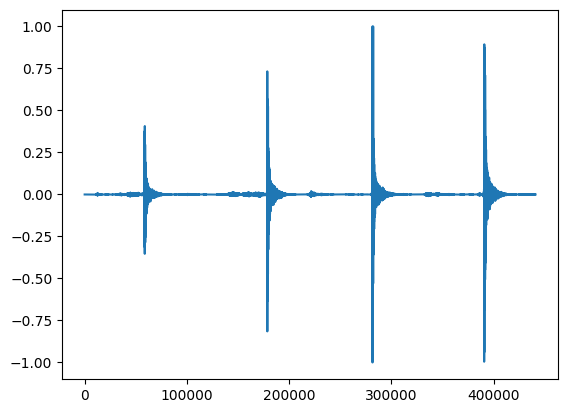

In [4]:
fig, ax = plt.subplots()
ax.plot(audio)

In [5]:
peaks, props = scipy.signal.find_peaks(audio, height=0.3, distance=0.1 * FS)
peak_heights = props["peak_heights"]
print(peaks, peak_heights)

[ 58844 178632 282187 390881] [0.40716553 0.73275757 0.99996948 0.89364624]


In [16]:
WINDOW_SIZE = 1000

def extract_impulse_response(signal: np.ndarray, plot: bool = False) -> np.ndarray:
    peak = signal[0]

    kernel = np.ones(WINDOW_SIZE) / WINDOW_SIZE
    filtered_signal = np.convolve(np.abs(signal), kernel, mode='same')

    response_cutoff = np.argmax(filtered_signal < 0.05 * np.max(filtered_signal))

    if plot:
        fig, axs = plt.subplots(2)
        axs[0].plot(signal)
        axs[0].axvline(response_cutoff, linestyle="--", color="r")
        axs[1].plot(filtered_signal)
        axs[1].axvline(response_cutoff, linestyle="--", color="r")

    return signal[:response_cutoff] / peak

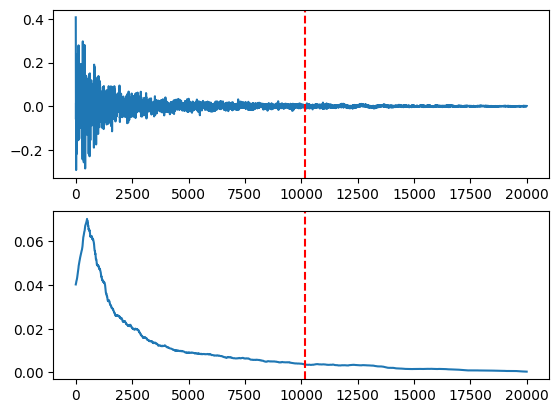

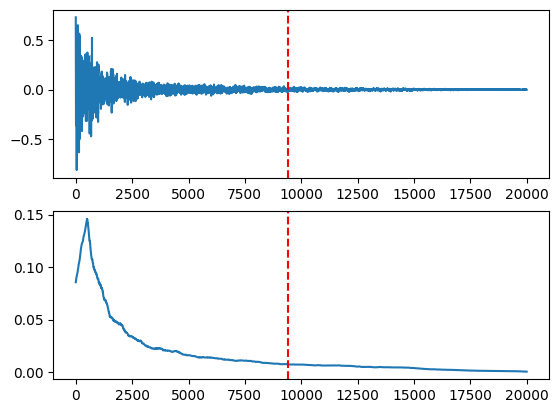

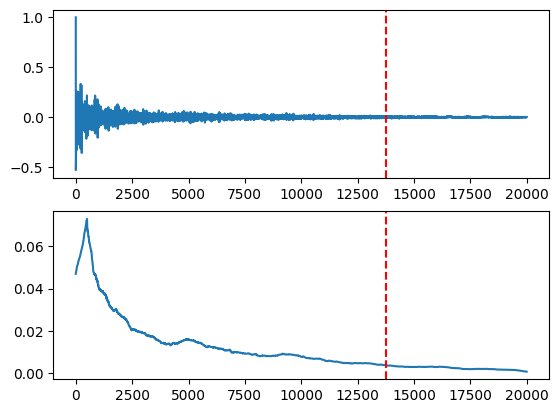

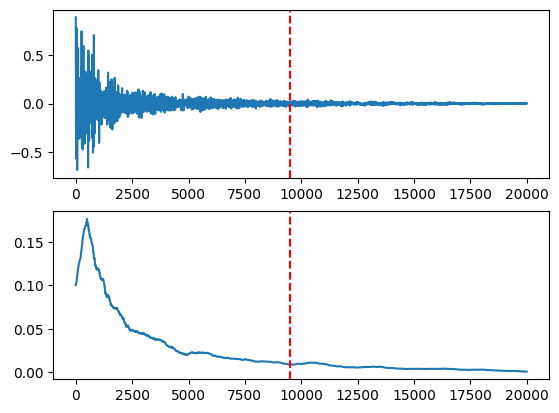

In [17]:
impulse_responses = [extract_impulse_response(audio[peak:peak+20000], plot=True) for peak in peaks]

In [8]:
def calculate_freq_gain(impulse_response: np.ndarray):
    freqs = np.fft.rfftfreq(impulse_response.size, d=1./FS)
    gains = np.fft.rfft(impulse_response)
    db_gains = 20 * np.log10(np.abs(gains))
    return freqs, db_gains

In [9]:
freq_gains = [calculate_freq_gain(resp) for resp in impulse_responses]

(5080,)
(4699,)
(6890,)
(4747,)


Text(0, 0.5, 'Gain (dB)')

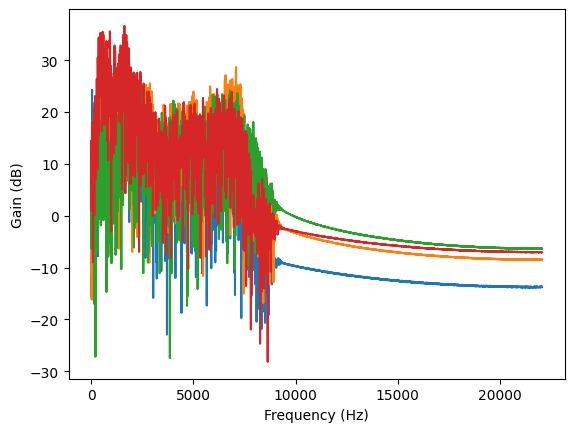

In [10]:
for freq, gain in freq_gains:
    print(freq.shape)
    plt.plot(freq, gain)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain (dB)")

In [11]:
min_length = min((freq.size for freq, gain in freq_gains))
trimmed_freq_gains = [(freq[:min_length], gain[:min_length]) for freq, gain in freq_gains]

In [12]:
print([freq for freq, gain in freq_gains])

[array([0.00000000e+00, 4.34140579e+00, 8.68281158e+00, ...,
       2.20413172e+04, 2.20456586e+04, 2.20500000e+04], shape=(5080,)), array([0.00000000e+00, 4.69348659e+00, 9.38697318e+00, ...,
       2.20406130e+04, 2.20453065e+04, 2.20500000e+04], shape=(4699,)), array([0.00000000e+00, 3.20052253e+00, 6.40104507e+00, ...,
       2.20419987e+04, 2.20451992e+04, 2.20483997e+04], shape=(6890,)), array([0.0000000e+00, 4.6460177e+00, 9.2920354e+00, ..., 2.2040708e+04,
       2.2045354e+04, 2.2050000e+04], shape=(4747,))]
